In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Veri setinin yüklenmesi ve ön işleme
df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

# mccinfo'dan "-" öncesindeki dört rakamı çıkarma
def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)

# mccinfo değeri bulunamayan satırların silinmesi
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

# Sayısal sütunlarda formatlama işlemleri
numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

# Kategorik sütunlar için LabelEncoder kullanımı
categorical_columns = ["Şehir", "İlçe", "mccinfo"]
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

print("Ön işleme tamamlandı.")

target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]

mccinfo değeri bulunamadığı için silinecek satır sayısı: 15
Ön işleme tamamlandı.


In [2]:
# Model ve Pipeline için gerekli modüllerin yüklenmesi
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Pipeline: Her fold’da eğitim seti üzerinde f_regression ile 10 en iyi öznitelik seçimi yapılıyor, ardından XGBoost modeli eğitiliyor.
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
    ('model', XGBRegressor(random_state=42))
])

# KFold cross validation: her fold’da öznitelik seçimi tekrarlanıyor.
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
y_pred = cross_val_predict(pipeline, X, y, cv=kfold)

# Değerlendirme metriklerinin hesaplanması
mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2: {r2:.4f}")



MAE: 0.2951
MAPE: 0.0711
R2: 0.6787


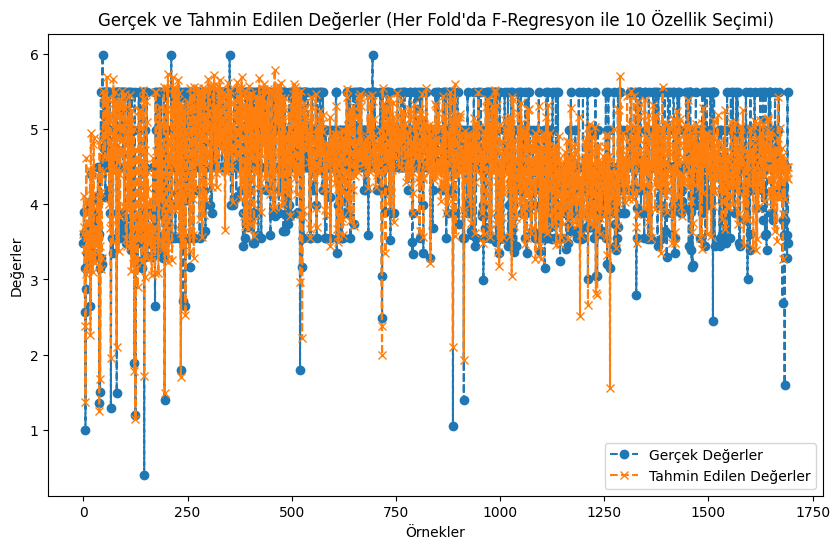

In [3]:
# -------------------- Grafik -------------------- #
plt.figure(figsize=(10, 6))
plt.plot(range(len(y)), y, label="Gerçek Değerler", marker="o", linestyle="--")
plt.plot(range(len(y_pred)), y_pred, label="Tahmin Edilen Değerler", marker="x", linestyle="--")
plt.xlabel("Örnekler")
plt.ylabel("Değerler")
plt.title("Gerçek ve Tahmin Edilen Değerler (Her Fold'da F-Regresyon ile 10 Özellik Seçimi)")
plt.legend()
plt.show()
